 GNP: Gross National Product - real, potential, unit labor cost, GNP/import/food/energy deflators
 
1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


In [4]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'

df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

print(df.shape)
df.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


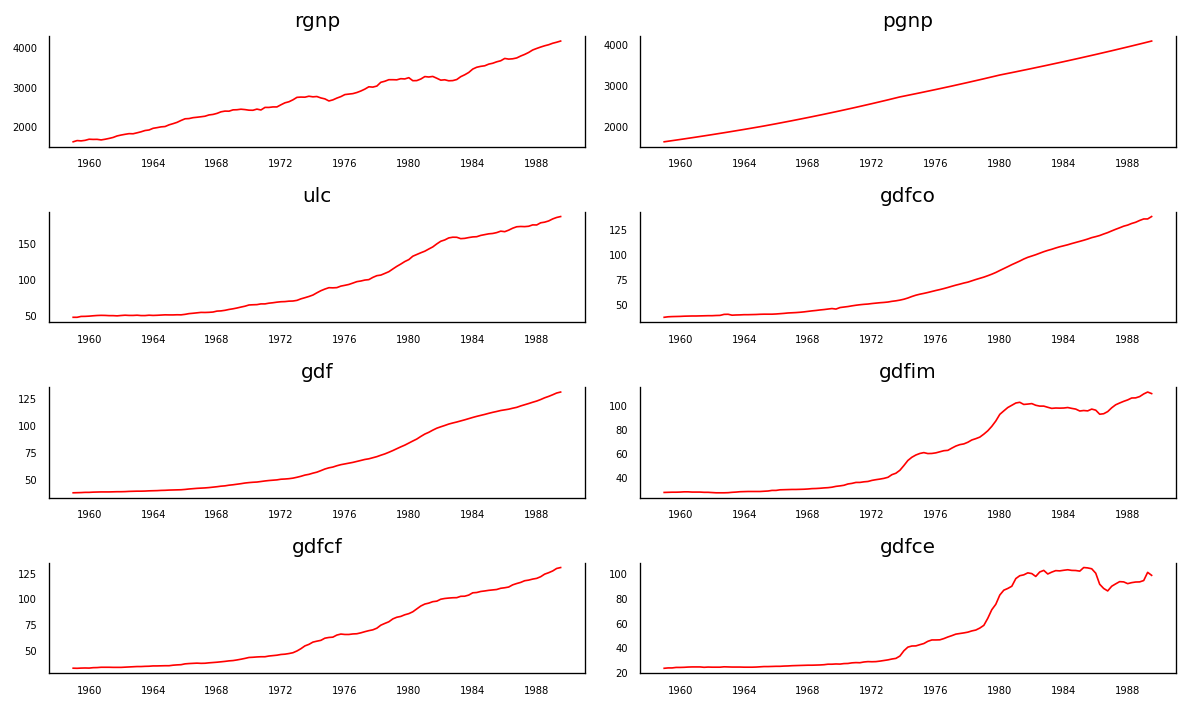

In [5]:
## visualization 
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

notice gdfce and gddfim

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):  
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


conclusion: all the variables are interchangeably causing each other (p-values < 0.05)

In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


conclusion: except gdfce, others have a long-run, statistically significant relationship.

In [8]:
# forecast the next 4 observations
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    if p_value <= signif:
        print(f" {name}: p-value    = {p_value} => Series is Stationary.")
    else:
        print(f" {name}: p-value    = {p_value} => Series is Non-Stationary.") 

# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)

 rgnp: p-value    = 0.9861 => Series is Non-Stationary.
 pgnp: p-value    = 0.9957 => Series is Non-Stationary.
 ulc: p-value    = 0.9963 => Series is Non-Stationary.
 gdfco: p-value    = 0.996 => Series is Non-Stationary.
 gdf: p-value    = 0.9981 => Series is Non-Stationary.
 gdfim: p-value    = 0.9514 => Series is Non-Stationary.
 gdfcf: p-value    = 0.9973 => Series is Non-Stationary.
 gdfce: p-value    = 0.9196 => Series is Non-Stationary.


conclusion: none of them is stationary

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)

 rgnp: p-value    = 0.0 => Series is Stationary.
 pgnp: p-value    = 0.3666 => Series is Non-Stationary.
 ulc: p-value    = 0.0089 => Series is Stationary.
 gdfco: p-value    = 0.5637 => Series is Non-Stationary.
 gdf: p-value    = 0.7034 => Series is Non-Stationary.
 gdfim: p-value    = 0.0009 => Series is Stationary.
 gdfcf: p-value    = 0.2632 => Series is Non-Stationary.
 gdfce: p-value    = 0.0228 => Series is Stationary.


In [10]:
# 2nd Differencing
df_differenced = df_differenced.diff().dropna()

# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)

 rgnp: p-value    = 0.0 => Series is Stationary.
 pgnp: p-value    = 0.0 => Series is Stationary.
 ulc: p-value    = 0.0 => Series is Stationary.
 gdfco: p-value    = 0.0 => Series is Stationary.
 gdf: p-value    = 0.0 => Series is Stationary.
 gdfim: p-value    = 0.0 => Series is Stationary.
 gdfcf: p-value    = 0.0 => Series is Stationary.
 gdfce: p-value    = 0.0 => Series is Stationary.


conclusion: all the series are now stationary

In [13]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i, ' - AIC : ', round(result.aic, 3), ' BIC : ', round(result.bic, 3), ' FPE : ', round(result.fpe, 3), ' HQIC: ', round(result.hqic, 3))

Lag Order = 1  - AIC :  -3.22  BIC :  -1.521  FPE :  0.04  HQIC:  -2.53
Lag Order = 2  - AIC :  -3.043  BIC :  0.185  FPE :  0.048  HQIC:  -1.733
Lag Order = 3  - AIC :  -3.226  BIC :  1.548  FPE :  0.042  HQIC:  -1.289
Lag Order = 4  - AIC :  -3.261  BIC :  3.075  FPE :  0.044  HQIC:  -0.69
Lag Order = 5  - AIC :  -3.164  BIC :  4.753  FPE :  0.056  HQIC:  0.049
Lag Order = 6  - AIC :  -3.167  BIC :  6.348  FPE :  0.07  HQIC:  0.694
Lag Order = 7  - AIC :  -3.138  BIC :  7.993  FPE :  0.103  HQIC:  1.378
Lag Order = 8  - AIC :  -3.685  BIC :  9.08  FPE :  0.103  HQIC:  1.492
Lag Order = 9  - AIC :  -4.706  BIC :  9.713  FPE :  0.086  HQIC:  1.141


/home/cdsw/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


conclusion: let's go with the lag 4 model (AIC drops to lowest at lag 4, then increases at lag 5 and then continuously drops further.

In [14]:
model_fitted = model.fit(4)

In [15]:
## checking for serial correlations of errors (residuals)
## [0,4]
## --> 2: no
## --> 0: positive
## --> 4: negative
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

rgnp   : 1.97
pgnp   : 2.1
ulc    : 2.12
gdfco  : 2.14
gdf    : 1.91
gdfim  : 2.01
gdfcf  : 1.99
gdfce  : 1.89


conclusion: we can forecast because the serial correlation seems quite alright.

In [16]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[62.8, 23.3,  1.9,  1.6,  1.2,  1.4,  1. , -0.2],
       [39.2, 23.5, -0.1,  1.1,  1.1,  1.2,  0.7, -1.4],
       [35.9, 23.6,  3. ,  1.6,  1.4,  1.6,  1.6,  0.8],
       [32. , 23.8,  0.9,  1.2,  1.6,  0.1,  2.5,  0.5]])

In [17]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,75.190554,24.783912,2.086423,1.737330,1.537475,0.241120,1.974500,0.383292
1989-01-01,31.195114,24.528025,1.355938,1.353183,1.609278,1.497334,2.079428,3.664665
1989-04-01,56.938632,24.548854,2.717204,1.606005,1.410746,1.673637,1.515554,1.980892
1989-07-01,-8.693158,23.945045,3.095821,1.536784,1.614513,1.764707,1.235764,2.266639


Note: there are the forecasts on the scale of the training data. So, de-differencing it 2 times to bring it back up to its original scale.

In [18]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4149.890554,4020.483912,182.586423,134.437330,128.037475,106.541120,127.974500,93.683292
1989-01-01,4288.276223,4093.595849,186.928784,138.727844,132.784228,108.379575,134.528429,98.231249
1989-04-01,4483.600522,4191.256639,193.988350,144.624363,138.941726,111.891666,142.597911,104.760098
1989-07-01,4670.231664,4312.862476,204.143736,152.057667,146.713737,117.168464,151.903157,113.555587


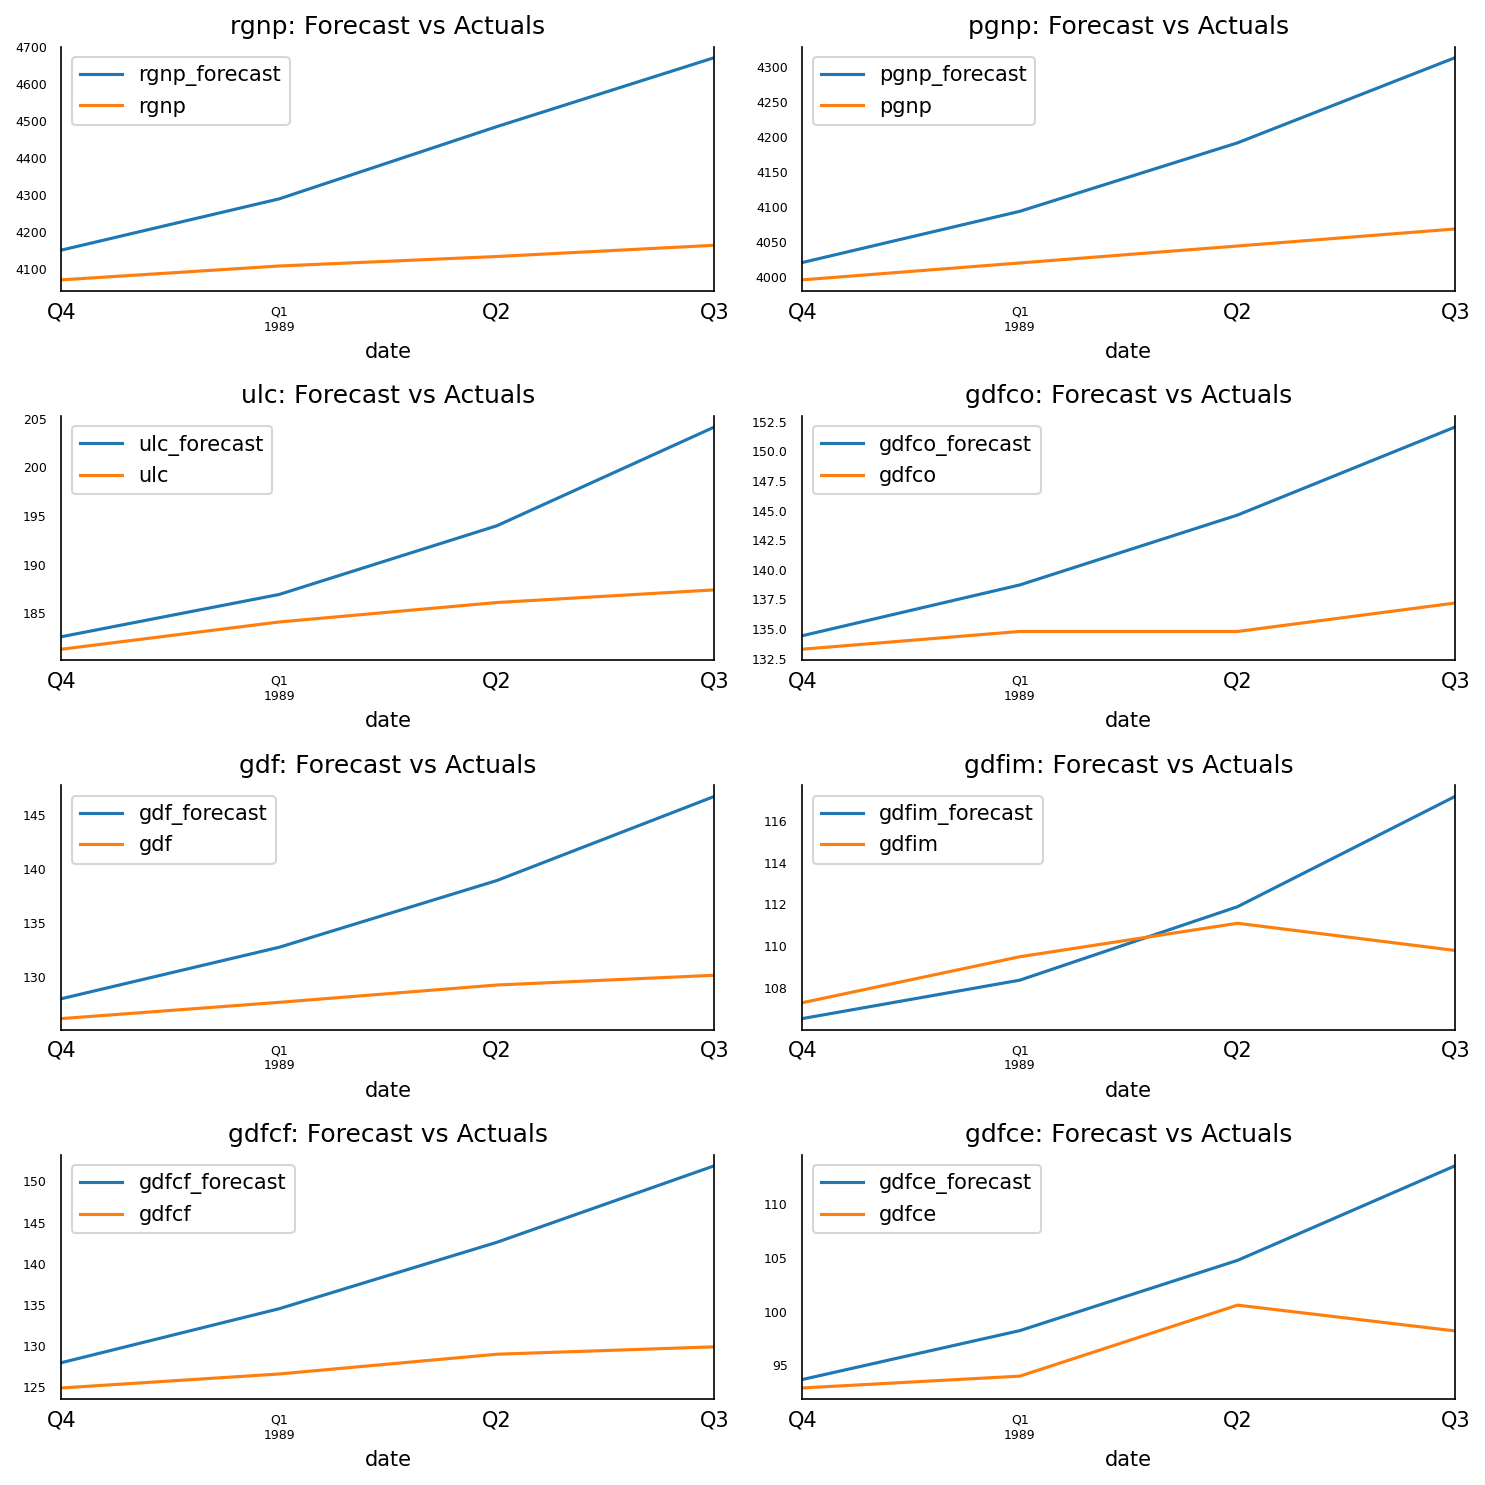

In [19]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [20]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.